<a href="https://colab.research.google.com/github/geanclm/Crewai_agentes_inteligentes/blob/main/crewai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imagem gerada através do DALLE3 no Copilot com o seguinte prompt:
# "Três agentes de inteligência artificial em reunião para uma tomada de decisão eficiente"

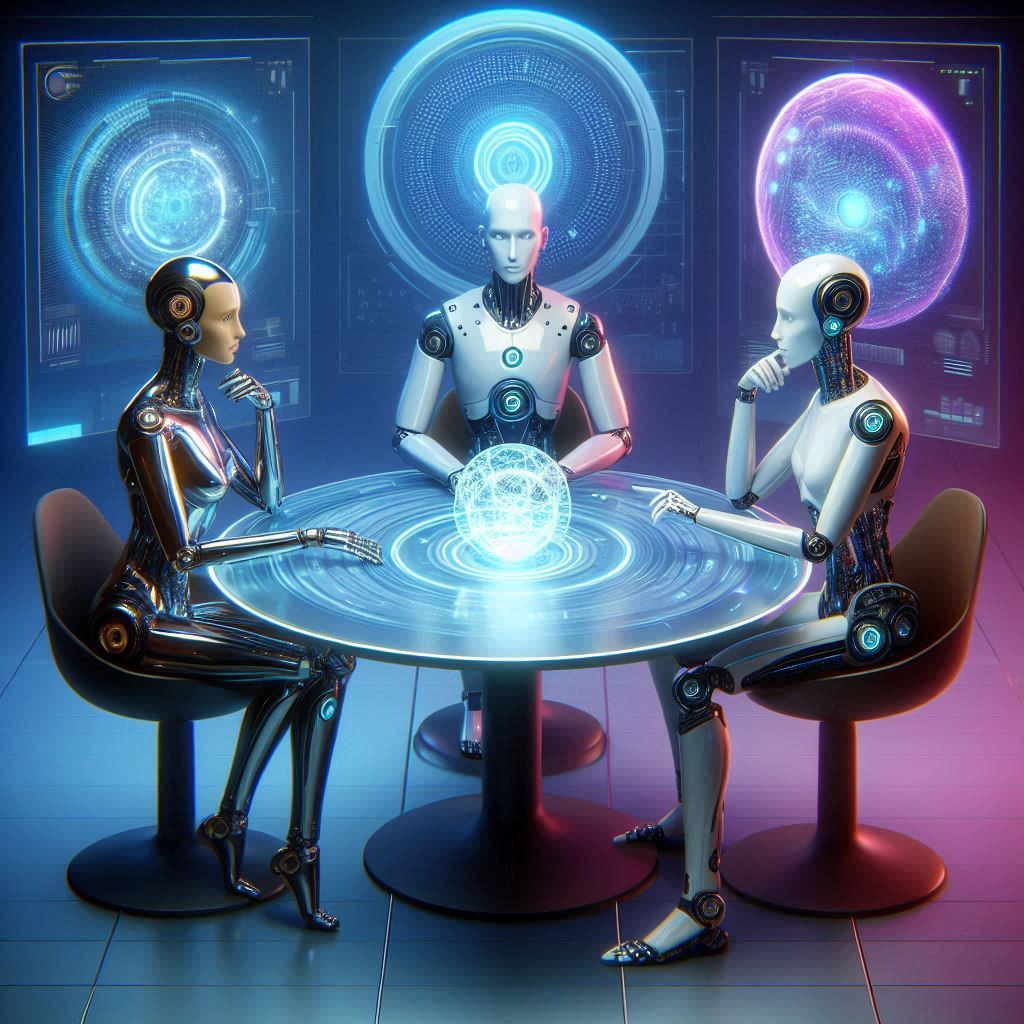

# AI AGENT - crewai

In [ ]:
# AI AGENT
# Equipe com 3 agentes de IA
# by geanclm on 13/06/2024 at 17:30h

# Insights:
# 0 - GPT não foi capaz de ajudar na instalação das bibliotecas necessárias para a execução do código;
# 1 - Limitação de tokens para a pesquisa de acordo com o modelo utilizado;
# 2 - O que extamente faz o CrewAI para integrar os agentes? É uma dúvida que surge a medida que se envolve com a tecnologia!
# Parece que o segredo está no "crew.kickoff"

# Instalar bibliotecas
!pip install --q crewai
!pip install --q langchain_groq
!pip install --q 'crewai[tools]'
!pip install crewai crewai-tools groq
!pip install requests beautifulsoup4 lxml

In [ ]:
# Importar bibliotecas necessárias
import os

import time
from datetime import datetime

from crewai import Agent, Task, Crew, Process
from crewai_tools.tools.scrape_website_tool.scrape_website_tool import ScrapeWebsiteTool
from langchain_groq import ChatGroq

In [ ]:
# - - - procedimento para salvar a key de forma segura
from google.colab import userdata
GROQ_API_KEY = userdata.get('api_groq_primeiro_projeto')
os.environ["GROQ_API_KEY"] = GROQ_API_KEY
api_key = os.environ["GROQ_API_KEY"]
# - - - procedimento para salvar a key de forma segura

In [ ]:
# Inicializar as variáveis
url_scrape_tool_escoladnc = 'https://www.escoladnc.com.br/blog/a-evolucao-da-inteligencia-artificial-da-origem-as-aplicacoes-atuais/#:~:text=A%20Evolu%C3%A7%C3%A3o%20da%20Intelig%C3%AAncia%20Artificial%20at%C3%A9%20os%20dias,padr%C3%B5es%20e%20tomar%20decis%C3%B5es%20com%20menor%20interven%C3%A7%C3%A3o%20humana'
scrape_tool_escoladnc = ScrapeWebsiteTool(website_url=url_scrape_tool_escoladnc)

url_scrape_tool_wikipedia = 'https://pt.wikipedia.org/wiki/Intelig%C3%AAncia_artificial'
scrape_tool_wikipedia = ScrapeWebsiteTool(website_url=url_scrape_tool_wikipedia)

# Definir a LLM
model = 'mixtral-8x7b-32768'

# Inicializar o Groq
llm = ChatGroq(model = model, api_key = api_key)

In [ ]:
# Funções utilizadas

# Salvar texto final da equipe em arquivo no Google Drive
def save_to_google_drive(autoria, texto):
    current_date = datetime.now().strftime("%Y-%m-%d")
    filename = f"{autoria}-{current_date}.txt"
    with open(filename, 'w', encoding='utf-8') as file:
        file.write(texto)

# Função para gerenciar o limite de taxa
def kickoff_with_rate_limiting(crew, inputs, delay=60):
    try:
        result = crew.kickoff(inputs=inputs)
        return result
    except Exception as e:
        print(f"Erro: {e}")
        if 'rate limit' in str(e).lower():
            print(f"Esperando {delay} segundos para evitar limite de taxa...")
            time.sleep(delay)
            return kickoff_with_rate_limiting(crew, inputs, delay)
        else:
            raise e

In [ ]:
# AGENTES
# versão 3 - equipe otimizada para melhor aproveitamento da API e menos requisições
# para superar o primeiro desafio das requisições, tamanho da janela de contexto e custo zero

# AGENTES SIMPLIFICADOS - 3 agentes inteligentes para produzir texto final
# Pesquisador e Organizador
pesquisador_organizador = Agent(
    role='Pesquisador e Organizador',
    goal='Buscar dados e informações sobre {topic} e organizá-los de forma lógica e didática.',
    verbose=True,
    memory=True,
    backstory=(
        "Você é um pesquisador experiente e meticuloso, sempre em busca de novas informações e dados relevantes "
        "para enriquecer o conhecimento sobre {topic}. Você também organiza esses dados de forma clara e lógica."
    ),
    tools=[scrape_tool_escoladnc, scrape_tool_wikipedia],
    llm=llm,
    allow_delegation=False,
    max_rpm=1,
)

# Redator e Revisor
redator_revisor = Agent(
    role='Redator e Revisor',
    goal='Redigir uma dissertação argumentativa em português do Brasil e de alto nível sobre {topic}, e revisar para garantir a qualidade.',
    verbose=True,
    memory=True,
    backstory=(
        "Você é um redator talentoso e um revisor crítico, com habilidades excepcionais em escrita e um olhar atento "
        "para detalhes gramaticais. Garante que cada texto seja coeso, coerente e envolvente, "
        "e revisa para garantir a melhor qualidade possível."
    ),
    llm=llm,
    allow_delegation=False,
    max_rpm=1,
)

# Validador-Publicador
validador_publicador = Agent(
    role='Validador e Publicador',
    goal='Validar o texto redigido e revisado e aprová-lo para publicação final.',
    verbose=True,
    memory=True,
    backstory=(
        "Você é um especialista em validação e propdução de conteúdos, garantindo que cada texto esteja pronto para ser exposto ao público. "
        "Sua responsabilidade é aprovar o trabalho final e liberar o texto para a exposição pública."
    ),
    llm=llm,
    allow_delegation=False,
    max_rpm=1,
)



# TAREFAS SIMPLIFICADAS
pesquisar_organizar_task = Task(
    description="Pesquisar notícias recentes sobre {topic} e organizar os dados coletados de forma lógica e didática.",
    expected_output="Um documento organizado com os tópicos mais relevantes sobre {topic}.",
    agent=pesquisador_organizador,
    allow_delegation=False,
)

redigir_revisar_task = Task(
    description="Redigir uma dissertação argumentativa em português do Brasil com 30 linhas sobre {topic}. "
                "Use as informações organizadas e revise para garantir correção gramatical, coesão e coerência.",
    expected_output='Uma dissertação argumentativa de 30 linhas sobre {topic}, revisada e pronta para ser apresentada.',
    agent=redator_revisor,
    async_execution=False,
    allow_delegation=False,
    output_file='dissertacao.md',
)

validar_publicar_task = Task(
    description="Validar o texto redigido e revisado e aprová-lo para publicação.",
    expected_output='Um texto validado e aprovado para exposição pública.',
    agent=validador_publicador,
    async_execution=False,
    allow_delegation=False,
)



# EQUIPE SIMPLIFICADA
crew = Crew(
    agents=[pesquisador_organizador, redator_revisor, validador_publicador],
    tasks=[pesquisar_organizar_task, redigir_revisar_task, validar_publicar_task],
    process=Process.sequential,  # Execução sequencial das tarefas
    manager_llm=llm,
)

In [ ]:
# # Executar
# result = crew.kickoff(inputs={'topic': 'Evolução da IA'})
# print(result)

# Executar com controle de limite de taxa de requisição
result = kickoff_with_rate_limiting(crew, inputs={'topic': 'Evolução da IA'})
print(result)



> Entering new CrewAgentExecutor chain...
In order to gather information about the latest developments in the evolution of AI, I will first read the content of the following website: "<https://www.escoladnc.com.br/blog/a-evolucao-da-inteligencia-artificial-da-origem-as-aplicacoes-atuais/#:~:text=A%20Evolu%C3%A7%C3%A3o%20da%20Intelig%C3%AAncia%20Artificial%20at%C3%A9%20os%20dias,padr%C3%B5es%20e%20tomar%20decis%C3%B5es%20com%20menor%20interven%C3%A7%C3%A3o%20humana>". This should provide me with a good understanding of the evolution of AI, from its origins to its current applications.

Action: Read website content
Action Input: {"url": "https://www.escoladnc.com.br/blog/a-evolucao-da-inteligencia-artificial-da-origem-as-aplicacoes-atuais/#:~:text=A%20Evolu%C3%A7%C3%A3o%20da%20Intelig%C3%AAncia%20Artificial%20at%C3%A9%20os%20dias,padr%C3%B5es%20e%20tomar%20decis%C3%B5es%20com%20menor%20interven%C3%A7%C3%A3o%20humana"}
 

A Evolução da Inteligência Artificial: Da Origem às Aplicações At

In [ ]:
save_to_google_drive('texto_final_da_equipe.txt', result)

# VERIFICAR GPU

In [ ]:
import tensorflow as tf

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]